<a href="https://colab.research.google.com/github/ericdnbn/nn_image_classifier_pneumonia/blob/main/Eric%E2%80%93nn_classifier_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test/' 

In [3]:
!find . -name ".DS_Store" -delete

In [4]:
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneu_dir = os.path.join(test_dir, 'PNEUMONIA')

val_normal_dir = os.path.join(val_dir, 'NORMAL')
val_pneu_dir = os.path.join(val_dir, 'PNEUMONIA')

In [5]:
train_normal_dir

'chest_xray/train/NORMAL'

In [6]:
len(os.listdir(train_normal_dir))

1242

In [7]:
# get all the data in the directory split/train (542 images), and reshape them
arg_dict = {'target_size':(100, 100), 
            'color_mode':'grayscale', 
            'batch_size':50}

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='training')


# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict) 


# get all the data in the directory split/validation (200 images), and reshape them
val_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='validation')


Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [8]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [9]:
train_images[0]

array([[[0.34901962],
        [0.32156864],
        [0.3254902 ],
        ...,
        [0.21568629],
        [0.227451  ],
        [0.20000002]],

       [[0.34509805],
        [0.34509805],
        [0.33333334],
        ...,
        [0.33333334],
        [0.23529413],
        [0.21568629]],

       [[0.34509805],
        [0.3529412 ],
        [0.35686275],
        ...,
        [0.21568629],
        [0.27058825],
        [0.2392157 ]],

       ...,

       [[0.07450981],
        [0.07058824],
        [0.0627451 ],
        ...,
        [0.07843138],
        [0.08235294],
        [0.09019608]],

       [[0.07450981],
        [0.07058824],
        [0.06666667],
        ...,
        [0.07843138],
        [0.08235294],
        [0.09019608]],

       [[0.07058824],
        [0.07450981],
        [0.06666667],
        ...,
        [0.07843138],
        [0.09019608],
        [0.09019608]]], dtype=float32)

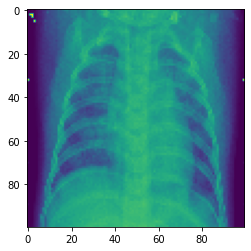

In [10]:
plt.imshow(train_images[3])

In [11]:
train_images.shape[0]

50

In [12]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 50
Number of testing samples: 50
Number of validation samples: 50
train_images shape: (50, 100, 100, 1)
train_labels shape: (50, 2)
test_images shape: (50, 100, 100, 1)
test_labels shape: (50, 2)
val_images shape: (50, 100, 100, 1)
val_labels shape: (50, 2)


In [13]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(50, 10000)
(50, 10000)
(50, 10000)


In [14]:
train_y = np.reshape(train_labels[:,0], (train_images.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_images.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_images.shape[0],1))

print(train_y)
print(test_y)
print(val_y)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]]


In [15]:
# First Simple Model
model = models.Sequential()

In [16]:
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [18]:
history = model.fit(train_img, 
                     train_y,
                     epochs=50,
                     batch_size=10,
                     validation_data=(val_img, val_y))

Epoch 1/50
5/5 [==============================] - 0s 80ms/step - loss: 0.7480 - accuracy: 0.4400 - recall: 0.3636 - val_loss: 0.6511 - val_accuracy: 0.8000 - val_recall: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6291 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.5668 - val_accuracy: 0.8000 - val_recall: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 0.5703 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.5194 - val_accuracy: 0.8000 - val_recall: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 24ms/step - loss: 0.5393 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.5029 - val_accuracy: 0.8000 - val_recall: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 0.5326 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.4964 - val_accuracy: 0.8000 - val_recall: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 0.5350 -

5/5 [==============================] - 0s 14ms/step - loss: 0.3624 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.4330 - val_accuracy: 0.8000 - val_recall: 0.0000e+00
Epoch 46/50
5/5 [==============================] - 0s 15ms/step - loss: 0.3219 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.3716 - val_accuracy: 0.8000 - val_recall: 0.0000e+00
Epoch 47/50
5/5 [==============================] - 0s 21ms/step - loss: 0.3435 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.3912 - val_accuracy: 0.8000 - val_recall: 0.0000e+00
Epoch 48/50
5/5 [==============================] - 0s 16ms/step - loss: 0.3912 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.3701 - val_accuracy: 0.8000 - val_recall: 0.0000e+00
Epoch 49/50
5/5 [==============================] - 0s 14ms/step - loss: 0.3227 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.4011 - val_accuracy: 0.8000 - val_recall: 0.0000e+00
Epoch 50/50
5/5 [==============================] - 0s 14ms/step - loss: 0.3596 - a

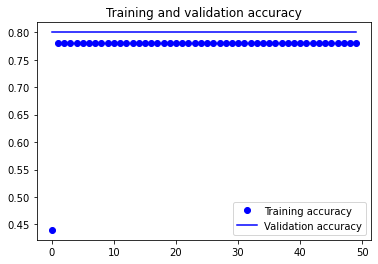

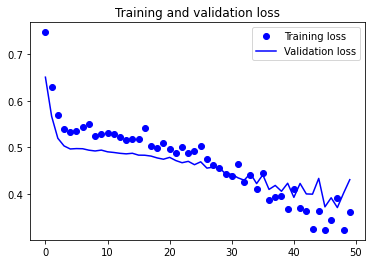

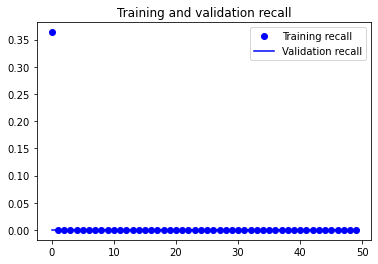

In [19]:

import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

In [20]:
results_train = model.evaluate(train_img, train_y)

2/2 [==============================] - 0s 3ms/step - loss: 0.3989 - accuracy: 0.7800 - recall: 0.0000e+00


In [21]:
results_train

[0.39889392256736755, 0.7799999713897705, 0.0]

In [22]:
results_test = model.evaluate(test_img, test_y)

2/2 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.7200 - recall: 0.0000e+00


In [23]:
results_test

[0.6374354958534241, 0.7200000286102295, 0.0]

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
preds = (model.predict(train_img) > 0.5).astype('int32')

cm = confusion_matrix(train_y, preds)

In [26]:
cm

array([[39,  0],
       [11,  0]])

In [27]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Nomral', 'Pneumonia'])

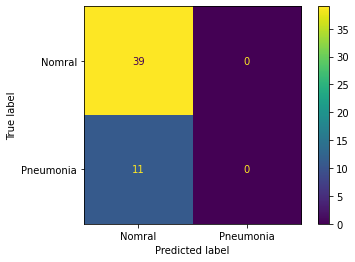

In [28]:
cmd.plot()

In [29]:
from sklearn.utils import class_weight

# Calculate floats/raw class weights
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

# Convert to dict for .fit(class_weight= ) param
nn_class_weights = {0:class_weights[0],
                    1:class_weights[1]}

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [30]:
def preprocessing_dense_data(train_directory=train_dir,
                             test_directory=test_dir,
                             ts_tuple=(256,256), 
                             color='grayscale', 
                             batch_size=None,
                             process_test=False):

    
    arg_dict = {'target_size':ts_tuple, 
                'color_mode':color, 
                'batch_size':batch_size}

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
       
    train_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='training') 

    val_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='validation')
    
    
    train_images, train_labels = next(train_generator)
    
    val_images, val_labels = next(val_generator)
    
    
    X_train = train_images.reshape(train_images.shape[0], -1)
    
    X_val = val_images.reshape(val_images.shape[0], -1)
    
    
    y_train = np.reshape(train_labels[:,0], (train_images.shape[0],1))
    
    y_val = np.reshape(val_labels[:,0], (val_images.shape[0],1))
    
    
    return X_train, X_val, y_train, y_val
    
    
    
    
    if process_test:
        
        test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict, subset='test')
        
        test_images, test_labels = next(test_generator)
        
        X_test = test_images.reshape(test_images.shape[0], -1)
        
        y_test = np.reshape(test_labels[:,0], (test_images.shape[0],1))
        
        return X_test, y_test
    
   
    
    


In [31]:
X_train, X_val, y_train, y_val = preprocessing_dense_data(batch_size=200)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [32]:
model2 = models.Sequential()

In [33]:
model2.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [35]:
history2 = model2.fit(X_train, 
                     y_train,
                     epochs=50,
                     batch_size=10,
                     validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 1s 46ms/step - loss: 0.9536 - accuracy: 0.6500 - recall: 0.2222 - val_loss: 0.5235 - val_accuracy: 0.7650 - val_recall: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 12ms/step - loss: 0.6252 - accuracy: 0.6800 - recall: 0.0741 - val_loss: 0.5458 - val_accuracy: 0.7650 - val_recall: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 0s 14ms/step - loss: 0.5814 - accuracy: 0.7300 - recall: 0.0000e+00 - val_loss: 0.6112 - val_accuracy: 0.7650 - val_recall: 0.0000e+00
Epoch 4/50
20/20 [==============================] - 0s 13ms/step - loss: 0.5388 - accuracy: 0.7300 - recall: 0.0000e+00 - val_loss: 0.4442 - val_accuracy: 0.7650 - val_recall: 0.0000e+00
Epoch 5/50
20/20 [==============================] - 0s 13ms/step - loss: 0.5014 - accuracy: 0.7300 - recall: 0.0000e+00 - val_loss: 0.6857 - val_accuracy: 0.7650 - val_recall: 0.0000e+00
Epoch 6/50
20/20 [==============================] - 0s 13ms/step - loss: 

20/20 [==============================] - 0s 11ms/step - loss: 0.1830 - accuracy: 0.9800 - recall: 0.9444 - val_loss: 0.1818 - val_accuracy: 0.9700 - val_recall: 0.9362
Epoch 47/50
20/20 [==============================] - 0s 10ms/step - loss: 0.1752 - accuracy: 0.9750 - recall: 0.9074 - val_loss: 0.7664 - val_accuracy: 0.3650 - val_recall: 1.0000
Epoch 48/50
20/20 [==============================] - 0s 11ms/step - loss: 0.2725 - accuracy: 0.8650 - recall: 0.9259 - val_loss: 0.2201 - val_accuracy: 0.9350 - val_recall: 0.9574
Epoch 49/50
20/20 [==============================] - 0s 10ms/step - loss: 0.1640 - accuracy: 0.9800 - recall: 0.9444 - val_loss: 0.1982 - val_accuracy: 0.9500 - val_recall: 0.9574
Epoch 50/50
20/20 [==============================] - 0s 11ms/step - loss: 0.1728 - accuracy: 0.9650 - recall: 0.9259 - val_loss: 0.1980 - val_accuracy: 0.9500 - val_recall: 0.9574


In [42]:
def visualize_nn(history, model, X_train, y_train, X_val, y_val):
    acc = history.history['accuracy']
    mean_acc = np.mean(history.history['accuracy'])
    val_acc = history.history['val_accuracy']
    mean_val_acc = np.mean(history.history['val_accuracy'])
    loss = history.history['loss']
    mean_loss = np.mean(history.history['loss'])
    val_loss = history.history['val_loss']
    mean_val_loss = np.mean(history.history['val_loss'])
    recall = history.history['recall']
    mean_recall = np.mean(history.history['recall'])
    val_recall = history.history['val_recall']
    mean_val_recall = np.mean(history.history['val_recall'])

    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()
    plt.show()
    
    
    print(f'Mean Training Accuracy: {mean_acc}')
    print(f'Mean Validation Accuracy: {mean_val_acc}')
    print('')
    print(f'Mean Training Loss: {mean_loss}')
    print(f'Mean Validation Loss: {mean_val_loss}')
    print('')
    print(f'Mean Training Recall: {mean_recall}')
    print(f'Mean Validation Recall: {mean_val_recall}')
    print('')
    print('Training Evaluation:')
    model.evaluate(X_train, y_train)
    print('')
    print('Validation Evaluation:')
    model.evaluate(X_val, y_val)
                                   
    
    
    preds = (model.predict(X_val) > 0.5).astype('int32')
    
    preds2 = (model.predict(X_train) > 0.5).astype('int32')

    cm = confusion_matrix(y_val, preds)
    
    cm2 = confusion_matrix(y_train, preds2)
    
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    
    cmd2 = ConfusionMatrixDisplay(cm2, display_labels=['Normal', 'Pneumonia'])
    
    print('Validation Confusion Matrix:')
    cmd.plot()
    print('')
    cmd2.plot()
    print('Training Confusion Matrix:');

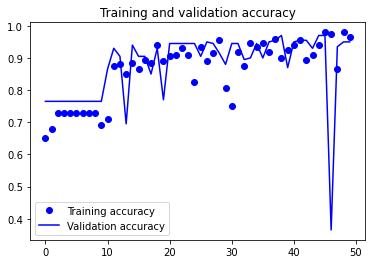

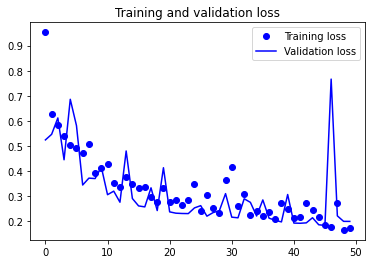

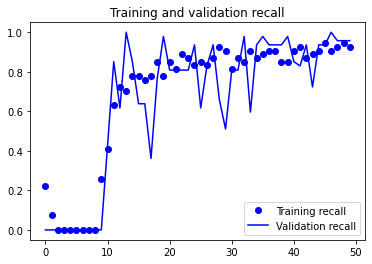

Mean Training Accuracy: 0.8653000020980834
Mean Validation Accuracy: 0.87739999294281

Mean Training Loss: 0.32982366770505905
Mean Validation Loss: 0.3088241481781006

Mean Training Recall: 0.685185187458992
Mean Validation Recall: 0.6565957492589951

Training Evaluation:
7/7 [==============================] - 0s 4ms/step - loss: 0.1541 - accuracy: 0.9850 - recall: 0.9815

Validation Evaluation:
7/7 [==============================] - 0s 4ms/step - loss: 0.1980 - accuracy: 0.9500 - recall: 0.9574


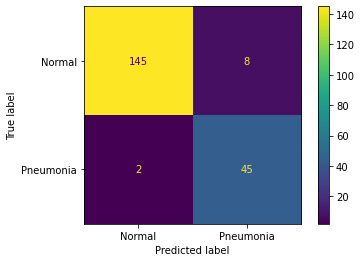

In [37]:
visualize_nn(history2, model2, X_train, y_train, X_val, y_val)

In [38]:
def nn_model(dense_list, 
             train_directory=train_dir,
             test_directory=test_dir,
             ts_tuple=(256,256), 
             color='grayscale',
             batch_size=1000,
             process_test=False,
             input_activation='relu',
             layer_activation='relu',
             output_activation='sigmoid',
             l2_rate=0.01,
             optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy', 'Recall'],
             epochs=50,
             bs=10):
    
    if not process_test:
        X_train, X_val, y_train, y_val = preprocessing_dense_data(batch_size=batch_size)
    
    else:
        X_train, X_test, X_val, y_train, y_test, y_val = preprocessing_dense_data(batch_size=batch_size)
    
    nn_model = models.Sequential()
    
    
    nn_model.add(layers.Dense(64, activation=input_activation, input_shape=(X_train.shape[1],)))
    
    for i, val in enumerate(dense_list):
        nn_model.add(layers.Dense(int(dense_list[i]), 
                                  activation=layer_activation,
                                  kernel_regularizer=l2(l2=l2_rate)))
        
        
    nn_model.add(layers.Dense(1, activation=output_activation))
        
    nn_model.compile(optimizer=optimizer,
                     loss=loss,
                     metrics=metrics)
    
    
    hist = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_val, y_val))
    
    visualize_nn(hist, nn_model, X_train, y_train, X_val, y_val)
    

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 2s 18ms/step - loss: 1.2095 - accuracy: 0.7330 - recall: 0.1037 - val_loss: 1.0851 - val_accuracy: 0.7440 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 2s 18ms/step - loss: 1.0838 - accuracy: 0.7620 - recall: 0.0456 - val_loss: 1.1229 - val_accuracy: 0.7440 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 2s 17ms/step - loss: 1.0579 - accuracy: 0.7590 - recall: 0.0000e+00 - val_loss: 0.9631 - val_accuracy: 0.7440 - val_recall: 0.0000e+00
Epoch 4/50
100/100 [==============================] - 2s 16ms/step - loss: 0.9513 - accuracy: 0.7860 - recall: 0.1411 - val_loss: 0.8710 - val_accuracy: 0.8670 - val_recall: 0.5156
Epoch 5/50
100/100 [==============================] - 2s 17ms/step - loss: 0.8738 - accuracy: 0.8580 - recall: 0.6307 - val_loss: 0.9428 - val_accuracy: 0.8110 - val_recall: 0.

100/100 [==============================] - 2s 17ms/step - loss: 0.2302 - accuracy: 0.9570 - recall: 0.9253 - val_loss: 0.2698 - val_accuracy: 0.9370 - val_recall: 0.8398
Epoch 46/50
100/100 [==============================] - 2s 16ms/step - loss: 0.2179 - accuracy: 0.9620 - recall: 0.9253 - val_loss: 0.2679 - val_accuracy: 0.9380 - val_recall: 0.9570
Epoch 47/50
100/100 [==============================] - 2s 16ms/step - loss: 0.2046 - accuracy: 0.9640 - recall: 0.9253 - val_loss: 0.2730 - val_accuracy: 0.9320 - val_recall: 0.8164
Epoch 48/50
100/100 [==============================] - 2s 16ms/step - loss: 0.1982 - accuracy: 0.9680 - recall: 0.9378 - val_loss: 0.2600 - val_accuracy: 0.9350 - val_recall: 0.8359
Epoch 49/50
100/100 [==============================] - 2s 16ms/step - loss: 0.1838 - accuracy: 0.9740 - recall: 0.9502 - val_loss: 0.2467 - val_accuracy: 0.9400 - val_recall: 0.9414
Epoch 50/50
100/100 [==============================] - 2s 17ms/step - loss: 0.2012 - accuracy: 0.9710 

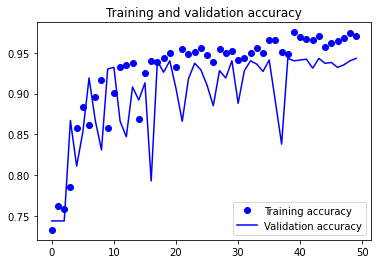

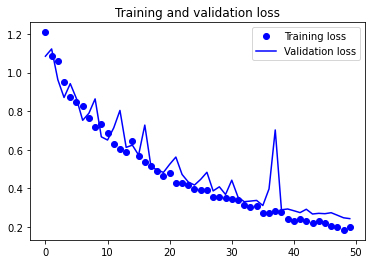

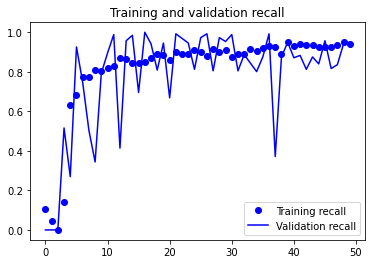

Mean Training Accuracy: 0.9256400012969971
Mean Validation Accuracy: 0.8991599977016449

Mean Training Loss: 0.4776243954896927
Mean Validation Loss: 0.5214155536890029

Mean Training Recall: 0.8141908781975508
Mean Validation Recall: 0.77953125

Training Evaluation:
32/32 [==============================] - 0s 8ms/step - loss: 0.1702 - accuracy: 0.9840 - recall: 0.9917

Validation Evaluation:
32/32 [==============================] - 0s 8ms/step - loss: 0.2423 - accuracy: 0.9430 - recall: 0.9492


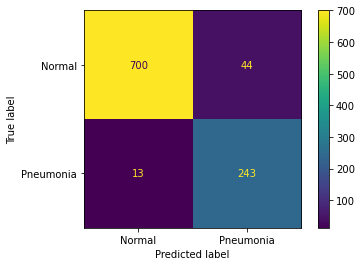

In [39]:
nn_model([32,16],batch_size=1000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 2s 20ms/step - loss: 1.3577 - accuracy: 0.7500 - recall: 0.0040 - val_loss: 1.3085 - val_accuracy: 0.7410 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 2s 18ms/step - loss: 1.2643 - accuracy: 0.7500 - recall: 0.0000e+00 - val_loss: 1.2214 - val_accuracy: 0.7410 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 2s 19ms/step - loss: 1.1907 - accuracy: 0.7500 - recall: 0.0000e+00 - val_loss: 1.3119 - val_accuracy: 0.7410 - val_recall: 0.0000e+00
Epoch 4/50
100/100 [==============================] - 2s 18ms/step - loss: 1.1501 - accuracy: 0.7500 - recall: 0.1160 - val_loss: 1.0042 - val_accuracy: 0.8420 - val_recall: 0.4247
Epoch 5/50
100/100 [==============================] - 2s 17ms/step - loss: 1.0480 - accuracy: 0.8170 - recall: 0.5920 - val_loss: 0.9661 - val_accuracy: 0.8440 - val_recall

100/100 [==============================] - 2s 17ms/step - loss: 0.2525 - accuracy: 0.9550 - recall: 0.9160 - val_loss: 0.2831 - val_accuracy: 0.9500 - val_recall: 0.9305
Epoch 46/50
100/100 [==============================] - 2s 16ms/step - loss: 0.2442 - accuracy: 0.9580 - recall: 0.9240 - val_loss: 0.3610 - val_accuracy: 0.9150 - val_recall: 0.7104
Epoch 47/50
100/100 [==============================] - 2s 17ms/step - loss: 0.2587 - accuracy: 0.9520 - recall: 0.9120 - val_loss: 0.2970 - val_accuracy: 0.9380 - val_recall: 0.9575
Epoch 48/50
100/100 [==============================] - 2s 17ms/step - loss: 0.2397 - accuracy: 0.9610 - recall: 0.9320 - val_loss: 0.4168 - val_accuracy: 0.8910 - val_recall: 0.9923
Epoch 49/50
100/100 [==============================] - 2s 16ms/step - loss: 0.2353 - accuracy: 0.9620 - recall: 0.9400 - val_loss: 0.2622 - val_accuracy: 0.9520 - val_recall: 0.9382
Epoch 50/50
100/100 [==============================] - 2s 17ms/step - loss: 0.2228 - accuracy: 0.9580 

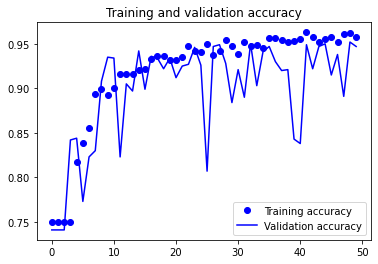

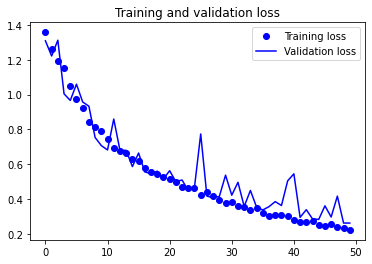

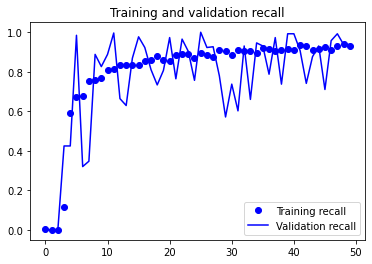

Mean Training Accuracy: 0.9186800014972687
Mean Validation Accuracy: 0.8974000000953675

Mean Training Loss: 0.5380469313263894
Mean Validation Loss: 0.5792651611566544

Mean Training Recall: 0.7984000013675541
Mean Validation Recall: 0.7671814692020417

Training Evaluation:
32/32 [==============================] - 0s 8ms/step - loss: 0.1892 - accuracy: 0.9750 - recall: 0.9560

Validation Evaluation:
32/32 [==============================] - 0s 8ms/step - loss: 0.2622 - accuracy: 0.9470 - recall: 0.9382


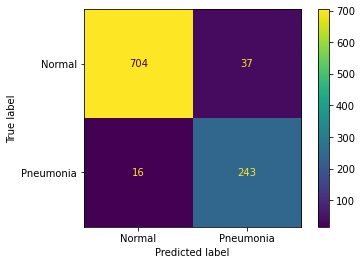

In [40]:
nn_model([32,16,8],batch_size=1000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 5s 46ms/step - loss: 1.3703 - accuracy: 0.7240 - recall: 0.0242 - val_loss: 1.2883 - val_accuracy: 0.7420 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 3s 28ms/step - loss: 1.2712 - accuracy: 0.7520 - recall: 0.0000e+00 - val_loss: 1.2445 - val_accuracy: 0.7420 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 3s 29ms/step - loss: 1.2122 - accuracy: 0.7500 - recall: 0.0202 - val_loss: 1.1354 - val_accuracy: 0.7430 - val_recall: 0.0039
Epoch 4/50
100/100 [==============================] - 3s 30ms/step - loss: 1.1011 - accuracy: 0.7960 - recall: 0.3306 - val_loss: 1.2533 - val_accuracy: 0.6610 - val_recall: 0.9922
Epoch 5/50
100/100 [==============================] - 3s 34ms/step - loss: 1.0086 - accuracy: 0.8350 - recall: 0.5806 - val_loss: 0.9202 - val_accuracy: 0.8720 - val_recall: 0.5388

100/100 [==============================] - 4s 43ms/step - loss: 0.2685 - accuracy: 0.9520 - recall: 0.9194 - val_loss: 0.2805 - val_accuracy: 0.9490 - val_recall: 0.8915
Epoch 46/50
100/100 [==============================] - 4s 41ms/step - loss: 0.2404 - accuracy: 0.9580 - recall: 0.9153 - val_loss: 0.3186 - val_accuracy: 0.9250 - val_recall: 0.7442
Epoch 47/50
100/100 [==============================] - 4s 38ms/step - loss: 0.2329 - accuracy: 0.9630 - recall: 0.9315 - val_loss: 0.2963 - val_accuracy: 0.9370 - val_recall: 0.9341
Epoch 48/50
100/100 [==============================] - 4s 35ms/step - loss: 0.2514 - accuracy: 0.9540 - recall: 0.9113 - val_loss: 0.2702 - val_accuracy: 0.9480 - val_recall: 0.8798
Epoch 49/50
100/100 [==============================] - 5s 48ms/step - loss: 0.2133 - accuracy: 0.9680 - recall: 0.9435 - val_loss: 0.2650 - val_accuracy: 0.9490 - val_recall: 0.8953
Epoch 50/50
100/100 [==============================] - 3s 33ms/step - loss: 0.2317 - accuracy: 0.9530 

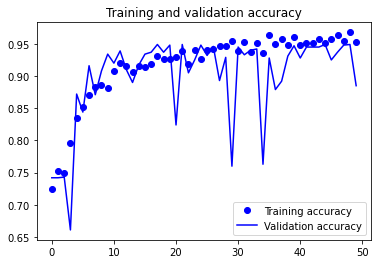

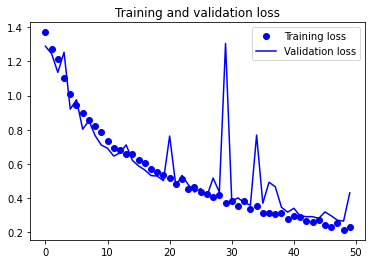

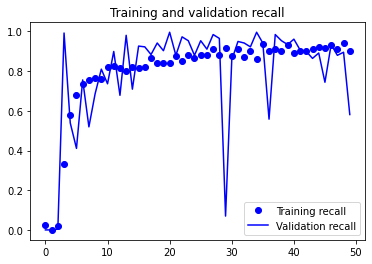

Mean Training Accuracy: 0.9169799983501434
Mean Validation Accuracy: 0.8996199977397918

Mean Training Loss: 0.5389422035217285
Mean Validation Loss: 0.5829888063669205

Mean Training Recall: 0.7968548371642828
Mean Validation Recall: 0.7892248069867491

Training Evaluation:
32/32 [==============================] - 0s 15ms/step - loss: 0.3753 - accuracy: 0.8970 - recall: 0.5887

Validation Evaluation:
32/32 [==============================] - 0s 15ms/step - loss: 0.4301 - accuracy: 0.8850 - recall: 0.5814
Validation Confusion Matrix:

Training Confusion Matrix:


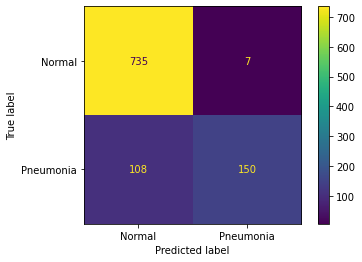

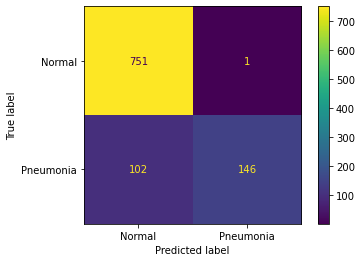

In [45]:
nn_model(dense_list=[32,16,10] ,batch_size=1000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 3s 28ms/step - loss: 1.0386 - accuracy: 0.7360 - recall: 0.0000e+00 - val_loss: 0.9379 - val_accuracy: 0.7430 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 2s 17ms/step - loss: 0.9346 - accuracy: 0.7360 - recall: 0.0000e+00 - val_loss: 0.8160 - val_accuracy: 0.7430 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 2s 17ms/step - loss: 0.8459 - accuracy: 0.8180 - recall: 0.5833 - val_loss: 0.8133 - val_accuracy: 0.7990 - val_recall: 0.2179
Epoch 4/50
100/100 [==============================] - 2s 17ms/step - loss: 0.8152 - accuracy: 0.8350 - recall: 0.6515 - val_loss: 0.7236 - val_accuracy: 0.9120 - val_recall: 0.7938
Epoch 5/50
100/100 [==============================] - 2s 19ms/step - loss: 0.7778 - accuracy: 0.8460 - recall: 0.7576 - val_loss: 0.6933 - val_accuracy: 0.9070 - val_recall: 0.

100/100 [==============================] - 2s 20ms/step - loss: 0.2261 - accuracy: 0.9650 - recall: 0.9432 - val_loss: 0.2534 - val_accuracy: 0.9500 - val_recall: 0.9455
Epoch 46/50
100/100 [==============================] - 2s 20ms/step - loss: 0.2122 - accuracy: 0.9710 - recall: 0.9508 - val_loss: 0.2522 - val_accuracy: 0.9500 - val_recall: 0.9494
Epoch 47/50
100/100 [==============================] - 2s 21ms/step - loss: 0.2147 - accuracy: 0.9690 - recall: 0.9432 - val_loss: 0.2575 - val_accuracy: 0.9470 - val_recall: 0.9572
Epoch 48/50
100/100 [==============================] - 2s 20ms/step - loss: 0.2206 - accuracy: 0.9560 - recall: 0.9242 - val_loss: 0.2905 - val_accuracy: 0.9290 - val_recall: 0.7743
Epoch 49/50
100/100 [==============================] - 2s 19ms/step - loss: 0.1934 - accuracy: 0.9770 - recall: 0.9508 - val_loss: 0.2436 - val_accuracy: 0.9480 - val_recall: 0.9416
Epoch 50/50
100/100 [==============================] - 2s 19ms/step - loss: 0.2074 - accuracy: 0.9630 

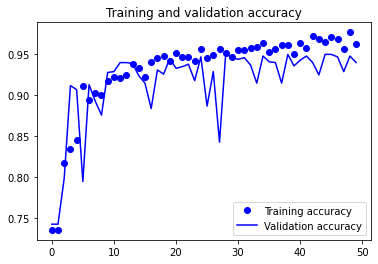

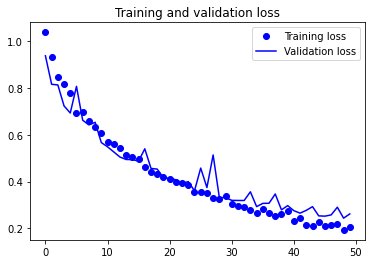

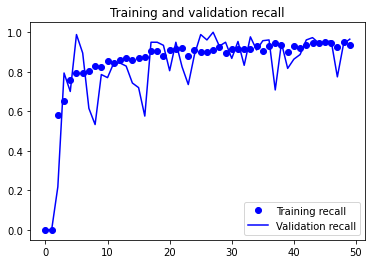

Mean Training Accuracy: 0.9314399969577789
Mean Validation Accuracy: 0.9160200023651123

Mean Training Loss: 0.4248039373755455
Mean Validation Loss: 0.44076781421899797

Mean Training Recall: 0.8479545474052429
Mean Validation Recall: 0.8173540779948234

Training Evaluation:
32/32 [==============================] - 0s 8ms/step - loss: 0.1818 - accuracy: 0.9780 - recall: 0.9962

Validation Evaluation:
32/32 [==============================] - 0s 9ms/step - loss: 0.2618 - accuracy: 0.9400 - recall: 0.9650
Validation Confusion Matrix:

Training Confusion Matrix:


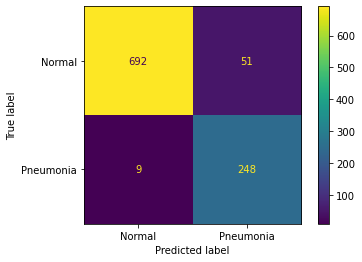

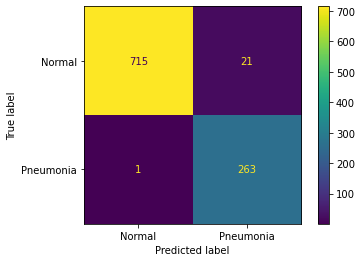

In [46]:
nn_model([16,8,4,2,2],batch_size=1000, ts_tuple=(512,512))

In [41]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))